In [1]:
import pandas as pd
from scipy.stats import zscore

In [2]:
df = pd.read_csv("LIWC-22 Results - daily_aggregation - LIWC Analysis.csv")
tone_df = pd.read_csv("LIWC-22 Results - daily_aggregation - LIWC Tone.csv")


In [3]:
df["date"] = pd.to_datetime(df[["year", "month", "day"]])
tone_df["date"] = pd.to_datetime(df[["year", "month", "day"]])

In [4]:
aid_map = {
    'aze': 'AZ',
    'dab': 'AZ',
    'frh': 'AZ',
    'nwg': 'NWT',
    'nwt': 'NWT',
    'wrz': 'WZ'
}

df['newspaper_group'] = df['aid'].map(aid_map)
tone_df['newspaper_group'] = tone_df['aid'].map(aid_map)

In [5]:
for col in ['prosocial', 'authority', 'sympathy', 'anger', 'trust', 'strength']:
    df[f'z_{col}'] = zscore(df[col])

z_cols = ['z_prosocial', 'z_authority', 'z_sympathy', 'z_anger', 'z_trust', 'z_strength']
df = df[df[z_cols].apply(lambda row: all(row.abs() <= 3), axis=1)].copy()

In [6]:
df['ratio_pros_auth'] = df['z_prosocial'] - df['z_authority']
df['ratio_sym_ang'] = df['z_sympathy'] - df['z_anger']
df['ratio_trust_str'] = df['z_trust'] - df['z_strength']

In [7]:
df['z_Prosociality_minus_Authoritarianism'] = zscore(df['ratio_pros_auth'])
df['z_Sympathy_minus_Anger'] = zscore(df['ratio_sym_ang'])
df['z_Trustworthiness_minus_Strength'] = zscore(df['ratio_trust_str'])

In [8]:
df = df[
    (df['z_Prosociality_minus_Authoritarianism'].abs() <= 3) &
    (df['z_Sympathy_minus_Anger'].abs() <= 3) &
    (df['z_Trustworthiness_minus_Strength'].abs() <= 3)
].copy()

In [9]:
merged_df = pd.merge(
    df,
    tone_df[['aid', 'date', 'Tone']],
    on=['aid', 'date'],
    how='left'
)

In [10]:
merged_df['z_Tone_std'] = zscore(merged_df['Tone'])
merged_df = merged_df[merged_df['z_Tone_std'].abs() <= 3].copy()

In [11]:
merged_df['time'] = (merged_df['date'] - pd.Timestamp("1905-01-01")).dt.days

In [12]:
def is_war(date):
    return int(
        (pd.Timestamp("1914-07-28") <= date <= pd.Timestamp("1918-11-11")) or
        (pd.Timestamp("1939-09-01") <= date <= pd.Timestamp("1945-05-08"))
    )

merged_df['war_binary'] = merged_df['date'].apply(is_war)

In [13]:
def get_regime_binary(date):
    if date <= pd.Timestamp("1918-11-11"):
        return 0
    elif pd.Timestamp("1918-11-12") <= date <= pd.Timestamp("1933-03-03"):
        return 1
    elif pd.Timestamp("1933-03-04") <= date <= pd.Timestamp("1938-03-12"):
        return 0
    elif pd.Timestamp("1938-03-13") <= date <= pd.Timestamp("1945-04-26"):
        return 0
    elif date >= pd.Timestamp("1945-04-27"):
        return 1
    else:
        return None

merged_df['regime_binary'] = merged_df['date'].apply(get_regime_binary)

In [14]:
final_df = merged_df[[
    'date', 'aid', 'newspaper_group', 'time',
    'z_Tone_std', 'regime_binary', 'war_binary',
    'z_Prosociality_minus_Authoritarianism',
    'z_Sympathy_minus_Anger',
    'z_Trustworthiness_minus_Strength'
]].dropna()

In [15]:
def h2b_equal_war_period(date):
    # WW1
    ww1_start = pd.Timestamp("1914-07-28")
    ww1_end = pd.Timestamp("1918-11-11")
    ww1_pre_start = ww1_start - pd.Timedelta(days=(ww1_end - ww1_start).days)
    ww1_pre_end = ww1_start - pd.Timedelta(days=1)

    # WW2
    ww2_start = pd.Timestamp("1939-09-01")
    ww2_end = pd.Timestamp("1945-05-08")
    ww2_pre_start = ww2_start - pd.Timedelta(days=(ww2_end - ww2_start).days)
    ww2_pre_end = ww2_start - pd.Timedelta(days=1)

    # Codierung
    if ww1_pre_start <= date <= ww1_pre_end:
        return 0  # Pre-WW1
    elif ww1_start <= date <= ww1_end:
        return 1  # WW1
    elif ww2_pre_start <= date <= ww2_pre_end:
        return 0  # Pre-WW2
    elif ww2_start <= date <= ww2_end:
        return 1  # WW2
    else:
        return None


In [16]:
final_df['war_period_h2b'] = final_df['date'].apply(h2b_equal_war_period)

In [17]:
print(final_df.head())

        date  aid newspaper_group  time  z_Tone_std  regime_binary  \
0 1905-01-01  aze              AZ     0    0.303252              0   
1 1905-01-02  aze              AZ     1   -0.768718              0   
2 1905-01-03  aze              AZ     2   -0.378779              0   
3 1905-01-04  aze              AZ     3   -1.051170              0   
4 1905-01-05  aze              AZ     4   -0.131995              0   

   war_binary  z_Prosociality_minus_Authoritarianism  z_Sympathy_minus_Anger  \
0           0                              -0.277626               -0.272176   
1           0                              -0.043524               -0.116288   
2           0                              -0.277626               -0.965411   
3           0                              -1.338409               -0.051633   
4           0                              -0.531943               -0.137840   

   z_Trustworthiness_minus_Strength  war_period_h2b  
0                          0.052522         

In [18]:
import statsmodels.formula.api as smf
from scipy.stats import zscore

# Liste der Ratios
ratios = {
    "Prosociality–Authoritarianism": "z_Prosociality_minus_Authoritarianism",
    "Sympathy–Anger": "z_Sympathy_minus_Anger",
    "Trust–Strength": "z_Trustworthiness_minus_Strength"
}

### -------------------- H1a -------------------- ###
print("\n==================== H1a ====================")
print("Demokratie vs. Autoritär (main effects only)\n")

h1a_results = {}

for name, col in ratios.items():
    final_df['z_ratio'] = zscore(final_df[col])

    model = smf.mixedlm(
        "z_ratio ~ time + regime_binary + z_Tone_std",
        final_df,
        groups=final_df["newspaper_group"]
    ).fit()
    
    h1a_results[name] = model.summary()
    print(f"\n=== H1a: {name} ===")
    print(model.summary())

### -------------------- H1b -------------------- ###
print("\n==================== H1b ====================")
print("Interaktion: Zeit × Regime\n")

h1b_results = {}

for name, col in ratios.items():
    final_df['z_ratio'] = zscore(final_df[col])

    model = smf.mixedlm(
        "z_ratio ~ time * regime_binary + z_Tone_std",
        final_df,
        groups=final_df["newspaper_group"]
    ).fit()
    
    h1b_results[name] = model.summary()
    print(f"\n=== H1b: {name} ===")
    print(model.summary())



==================== H1a ====================
Demokratie vs. Autoritär (main effects only)


=== H1a: Prosociality–Authoritarianism ===
          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: z_ratio    
No. Observations: 39533   Method:             REML       
No. Groups:       3       Scale:              0.9233     
Min. group size:  11986   Log-Likelihood:     -54547.2314
Max. group size:  14486   Converged:          Yes        
Mean group size:  13177.7                                
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept      -0.263    0.173 -1.521 0.128 -0.602  0.076
time            0.000    0.000 24.339 0.000  0.000  0.000
regime_binary   0.117    0.011 10.890 0.000  0.096  0.138
z_Tone_std      0.121    0.005 22.808 0.000  0.110  0.131
Group Var       0.089    0.096                           



/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood opti


=== H1a: Sympathy–Anger ===
          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: z_ratio    
No. Observations: 39533   Method:             REML       
No. Groups:       3       Scale:              0.8365     
Min. group size:  11986   Log-Likelihood:     -52592.7052
Max. group size:  14486   Converged:          No         
Mean group size:  13177.7                                
---------------------------------------------------------
              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept     -0.078    0.029  -2.721 0.006 -0.134 -0.022
time          -0.000    0.000 -13.205 0.000 -0.000 -0.000
regime_binary  0.370    0.010  36.322 0.000  0.350  0.390
z_Tone_std     0.358    0.005  71.065 0.000  0.348  0.368
Group Var      0.002    0.001                            



/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood opti


=== H1a: Trust–Strength ===
          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: z_ratio    
No. Observations: 39533   Method:             REML       
No. Groups:       3       Scale:              0.9432     
Min. group size:  11986   Log-Likelihood:     -54964.9523
Max. group size:  14486   Converged:          No         
Mean group size:  13177.7                                
---------------------------------------------------------
              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept      0.365    0.030  11.978 0.000  0.305  0.424
time          -0.000    0.000 -44.254 0.000 -0.000 -0.000
regime_binary  0.038    0.011   3.467 0.001  0.016  0.059
z_Tone_std    -0.012    0.005  -2.241 0.025 -0.022 -0.001
Group Var      0.003    0.001                            


==================== H1b ====================
Interaktion: Zeit × Regime


=== H1b: Prosociality–Authoritaria

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(



=== H1b: Sympathy–Anger ===
            Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  z_ratio    
No. Observations:    39533    Method:              REML       
No. Groups:          3        Scale:               0.8307     
Min. group size:     11986    Log-Likelihood:      -52469.0795
Max. group size:     14486    Converged:           Yes        
Mean group size:     13177.7                                  
--------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept           0.011    0.061   0.178 0.859 -0.108  0.130
time               -0.000    0.000 -20.848 0.000 -0.000 -0.000
regime_binary       0.074    0.021   3.559 0.000  0.033  0.114
time:regime_binary  0.000    0.000  16.462 0.000  0.000  0.000
z_Tone_std          0.342    0.005  66.980 0.000  0.332  0.352
Group Var           0.011    0.012     

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(



=== H1b: Trust–Strength ===
            Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  z_ratio    
No. Observations:    39533    Method:              REML       
No. Groups:          3        Scale:               0.9432     
Min. group size:     11986    Log-Likelihood:      -54976.9481
Max. group size:     14486    Converged:           Yes        
Mean group size:     13177.7                                  
--------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept           0.365    0.031  11.792 0.000  0.305  0.426
time               -0.000    0.000 -33.166 0.000 -0.000 -0.000
regime_binary       0.035    0.022   1.600 0.110 -0.008  0.078
time:regime_binary  0.000    0.000   0.119 0.905 -0.000  0.000
z_Tone_std         -0.012    0.005  -2.226 0.026 -0.023 -0.001
Group Var           0.003    0.001     

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [19]:
### -------------------- H2a -------------------- ###
print("\n==================== H2a ====================")
print("Krieg vs. Frieden (main effects only)\n")

h2a_results = {}

for name, col in ratios.items():
    final_df['z_ratio'] = zscore(final_df[col])

    model = smf.mixedlm(
        "z_ratio ~ time + war_binary + z_Tone_std",
        final_df,
        groups=final_df["newspaper_group"]
    ).fit()

    h2a_results[name] = model.summary()
    print(f"\n=== H2a: {name} ===")
    print(model.summary())


### -------------------- H2b -------------------- ###
print("\n==================== H2b ====================")
print("Interaktion: Zeit × Krieg (nur definierte Kriegs- & Pre-Kriegsperioden)\n")

# Nur Daten mit definierter H2b-Periode (WW1 und WW2 Zeiträume & gleich lange Pre-Perioden)
h2b_df = final_df[final_df['war_period_h2b'].notna()].copy()
h2b_df['war_period_h2b'] = h2b_df['war_period_h2b'].astype(int)

h2b_results = {}

for name, col in ratios.items():
    h2b_df['z_ratio'] = zscore(h2b_df[col])

    model = smf.mixedlm(
        "z_ratio ~ time * war_period_h2b + z_Tone_std",
        h2b_df,
        groups=h2b_df["newspaper_group"]
    ).fit()

    h2b_results[name] = model.summary()
    print(f"\n=== H2b: {name} ===")
    print(model.summary())



==================== H2a ====================
Krieg vs. Frieden (main effects only)


=== H2a: Prosociality–Authoritarianism ===
          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: z_ratio    
No. Observations: 39533   Method:             REML       
No. Groups:       3       Scale:              0.9243     
Min. group size:  11986   Log-Likelihood:     -54568.9653
Max. group size:  14486   Converged:          Yes        
Mean group size:  13177.7                                
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept      -0.226    0.165 -1.363 0.173 -0.550  0.099
time            0.000    0.000 31.101 0.000  0.000  0.000
war_binary     -0.124    0.014 -8.628 0.000 -0.152 -0.096
z_Tone_std      0.120    0.005 22.571 0.000  0.109  0.130
Group Var       0.082    0.081                           


=== H2a:

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



=== H2a: Trust–Strength ===
          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: z_ratio    
No. Observations: 39533   Method:             REML       
No. Groups:       3       Scale:              0.8840     
Min. group size:  11986   Log-Likelihood:     -53684.4651
Max. group size:  14486   Converged:          Yes        
Mean group size:  13177.7                                
---------------------------------------------------------
              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept      0.468    0.029  15.880 0.000  0.410  0.526
time          -0.000    0.000 -47.990 0.000 -0.000 -0.000
war_binary    -0.725    0.014 -51.553 0.000 -0.753 -0.698
z_Tone_std    -0.022    0.005  -4.161 0.000 -0.032 -0.011
Group Var      0.002    0.001                            


==================== H2b ====================
Interaktion: Zeit × Krieg (nur definierte Kriegs- & Pre-Kriegsp

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


In [20]:
### -------------------- H3 -------------------- ###
print("\n==================== H3 ====================")
print("Effekte von Regime und Krieg gemeinsam mit Zeitinteraktionen\n")

h3_results = {}

for name, col in ratios.items():
    final_df['z_ratio'] = zscore(final_df[col])

    model = smf.mixedlm(
        "z_ratio ~ time * regime_binary + time * war_binary + z_Tone_std",
        final_df,
        groups=final_df["newspaper_group"]
    ).fit()

    h3_results[name] = model.summary()
    print(f"\n=== H3: {name} ===")
    print(model.summary())



==================== H3 ====================
Effekte von Regime und Krieg gemeinsam mit Zeitinteraktionen


=== H3: Prosociality–Authoritarianism ===
            Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  z_ratio    
No. Observations:   39533    Method:              REML       
No. Groups:         3        Scale:               0.9214     
Min. group size:    11986    Log-Likelihood:      -54532.9925
Max. group size:    14486    Converged:           Yes        
Mean group size:    13177.7                                  
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept          -0.272    0.175 -1.553 0.120 -0.615  0.071
time                0.000    0.000 18.419 0.000  0.000  0.000
regime_binary       0.212    0.022  9.471 0.000  0.168  0.256
time:regime_binary -0.000    0.000 -5.666 0.000 -0.000 

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(



=== H3: Trust–Strength ===
            Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  z_ratio    
No. Observations:    39533    Method:              REML       
No. Groups:          3        Scale:               0.8704     
Min. group size:     11986    Log-Likelihood:      -53405.1930
Max. group size:     14486    Converged:           Yes        
Mean group size:     13177.7                                  
--------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept           0.425    0.055   7.776 0.000  0.318  0.532
time               -0.000    0.000 -11.851 0.000 -0.000 -0.000
regime_binary      -0.035    0.022  -1.611 0.107 -0.078  0.008
time:regime_binary -0.000    0.000 -11.253 0.000 -0.000 -0.000
war_binary         -0.546    0.028 -19.190 0.000 -0.601 -0.490
time:war_binary    -0.000    0.000 -13.3

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


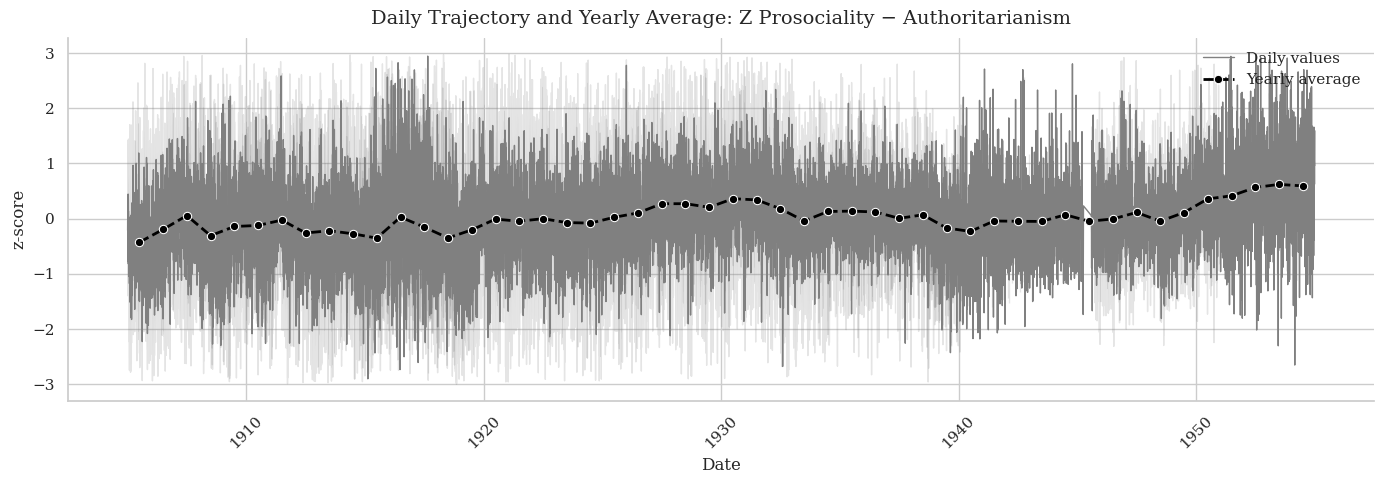

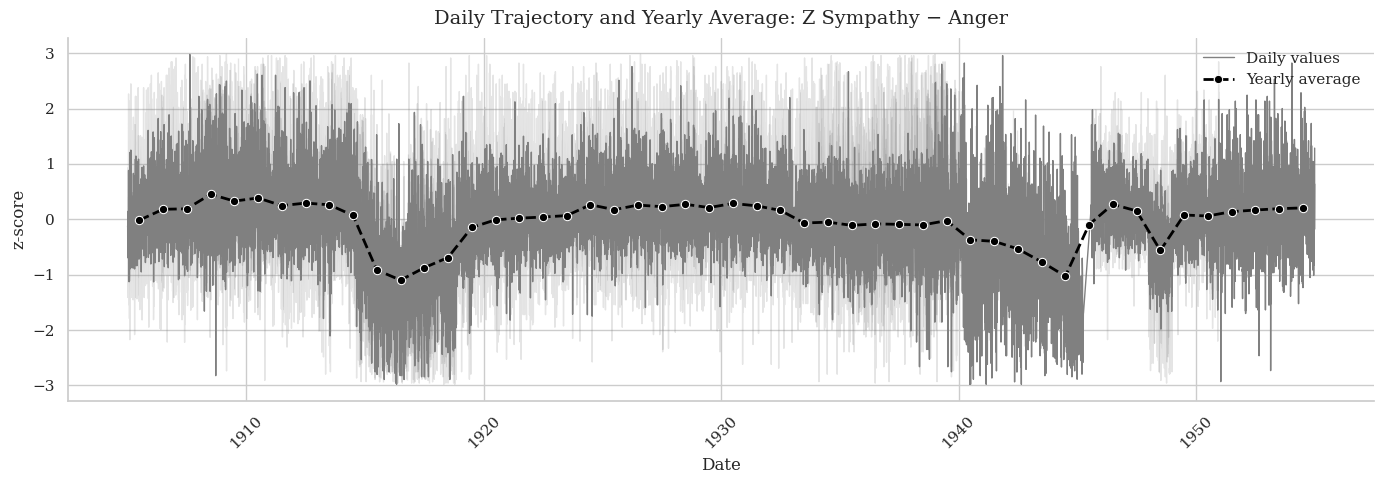

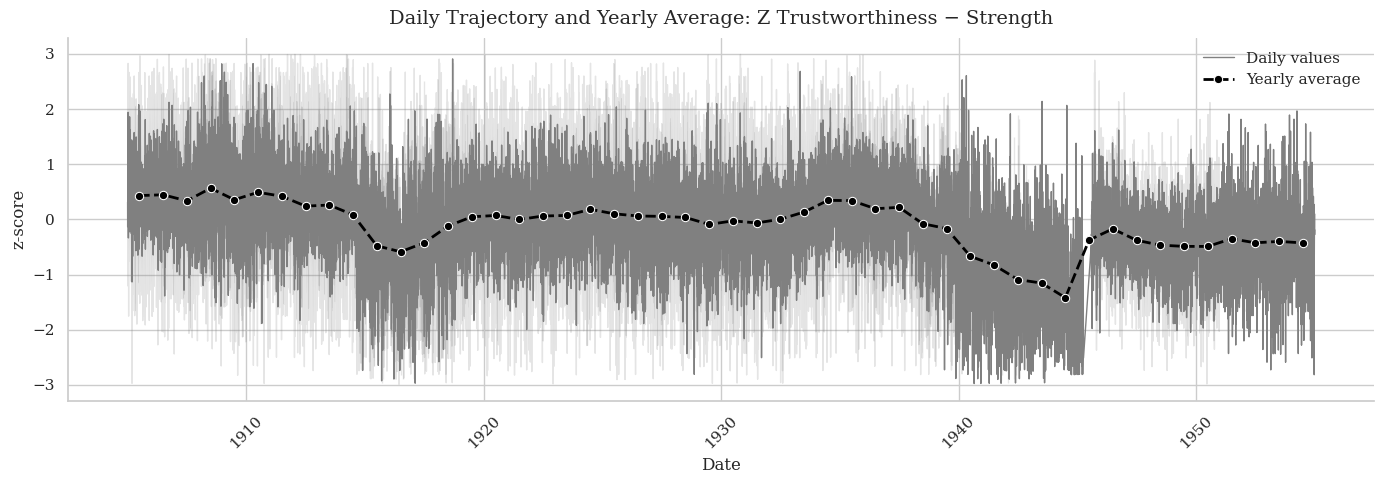

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#  APA-style 
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    "font.family": "serif",         
    "font.size": 12,
    "axes.labelsize": 12,
    "axes.titlesize": 14,
    "legend.fontsize": 11
})

# Convert date and extract year
final_df["date"] = pd.to_datetime(final_df["date"])
final_df["year"] = final_df["date"].dt.year

# Define the ratios to plot
ratios = [
    "z_Prosociality_minus_Authoritarianism",
    "z_Sympathy_minus_Anger",
    "z_Trustworthiness_minus_Strength"
]

# Loop through each ratio
for ratio in ratios:
    df_day = final_df[["date", ratio]].dropna()
    df_day["year"] = df_day["date"].dt.year

    # Calculate yearly average
    df_year = df_day.groupby("year")[ratio].mean().reset_index()
    df_year["date"] = pd.to_datetime(df_year["year"].astype(str) + "-07-01")

    # Create combined plot
    fig, ax = plt.subplots(figsize=(14, 5))

    # Plot daily values (gray thin line)
    sns.lineplot(data=df_day, x="date", y=ratio, ax=ax,
                 label="Daily values", color="gray", linewidth=1)

    # Plot yearly average (black dashed line with markers)
    sns.lineplot(data=df_year, x="date", y=ratio, ax=ax,
                 label="Yearly average", color="black",
                 linewidth=2, marker="o", linestyle="--")

    # Title and axis labels in English
    readable_label = ratio.replace("_", " ").replace("minus", "−").title()
    ax.set_title(f"Daily Trajectory and Yearly Average: {readable_label}", pad=10)
    ax.set_xlabel("Date")
    ax.set_ylabel("z-score")

    # Rotate x-axis ticks for readability
    ax.tick_params(axis='x', rotation=45)

    # Legend: no box, top right
    ax.legend(loc="upper right", frameon=False)

    # APA-style: remove top and right spines
    sns.despine()
    plt.tight_layout()
    plt.show()


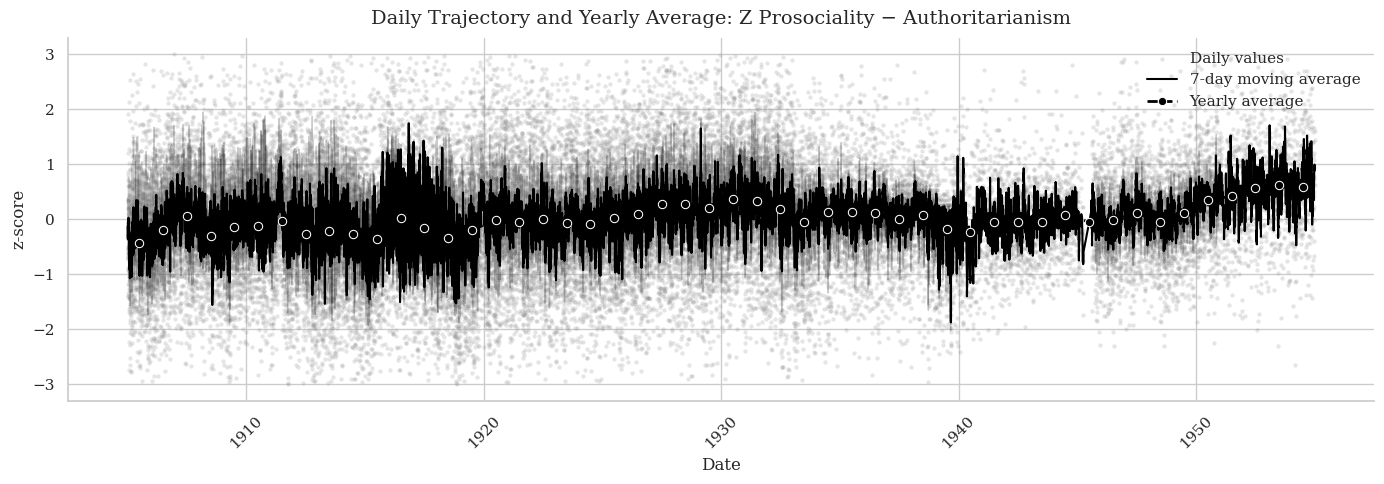

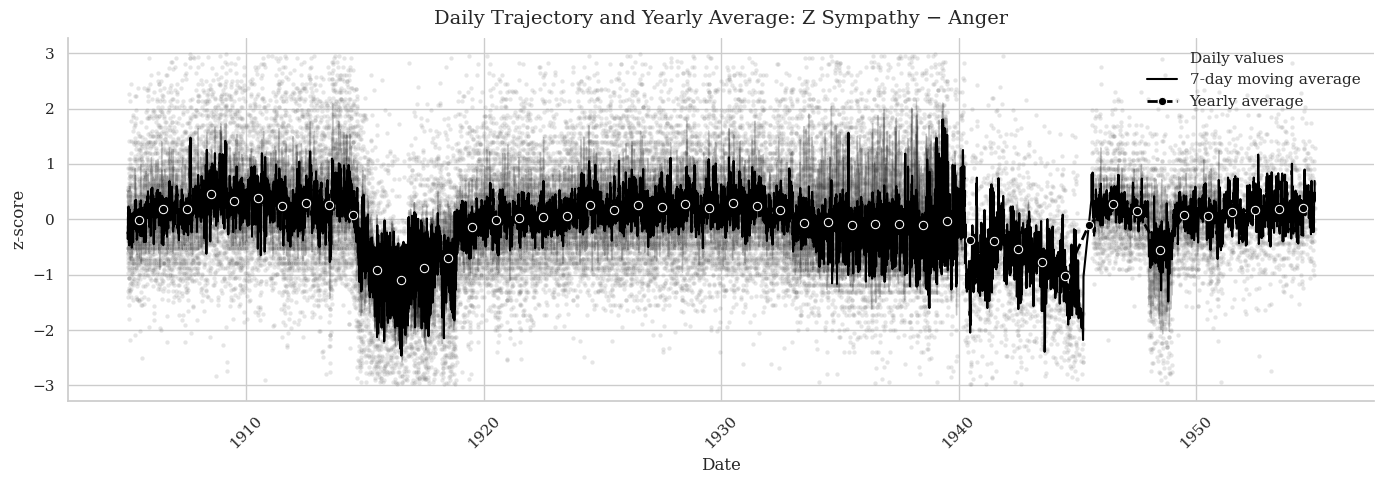

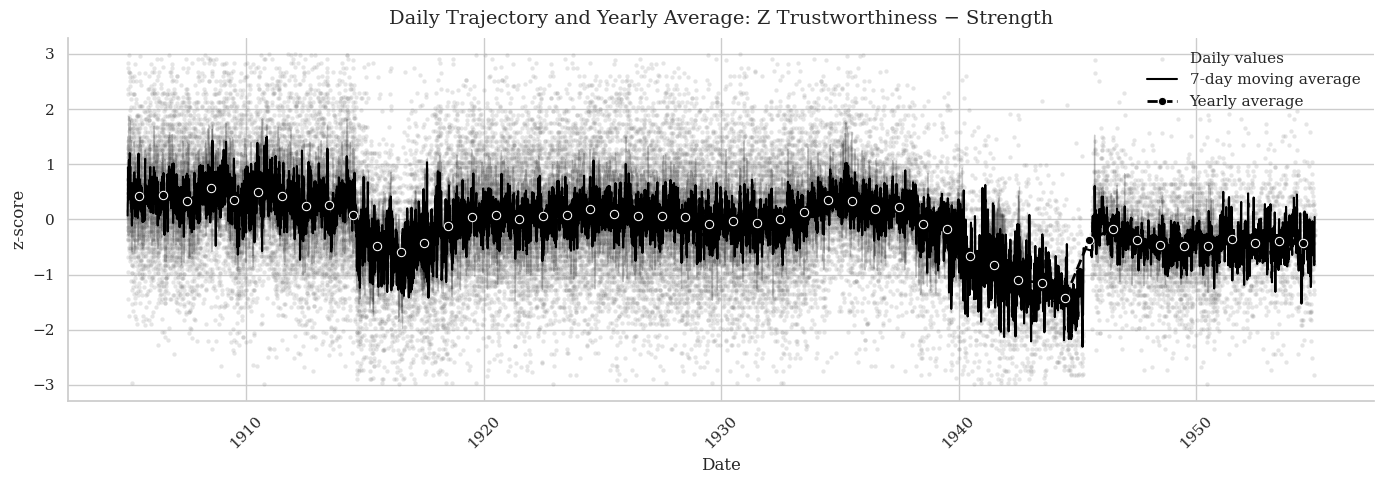

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set APA-style parameters
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    "font.family": "serif",         # APA-compatible serif font
    "font.size": 12,
    "axes.labelsize": 12,
    "axes.titlesize": 14,
    "legend.fontsize": 11
})

# Ensure datetime format and extract year
final_df["date"] = pd.to_datetime(final_df["date"])
final_df["year"] = final_df["date"].dt.year

# Define the variables to plot
ratios = [
    "z_Prosociality_minus_Authoritarianism",
    "z_Sympathy_minus_Anger",
    "z_Trustworthiness_minus_Strength"
]

for ratio in ratios:
    df_day = final_df[["date", ratio]].dropna().copy()
    df_day["year"] = df_day["date"].dt.year

    # Calculate 7-day centered rolling average
    df_day["smoothed"] = df_day[ratio].rolling(window=7, center=True).mean()

    # Calculate yearly average
    df_year = df_day.groupby("year")[ratio].mean().reset_index()
    df_year["date"] = pd.to_datetime(df_year["year"].astype(str) + "-07-01")

    # Create the plot
    fig, ax = plt.subplots(figsize=(14, 5))

    # Plot raw daily values as semi-transparent points
    sns.scatterplot(data=df_day, x="date", y=ratio, ax=ax,
                    label="Daily values", color="gray", alpha=0.2, s=10)

    # Plot 7-day smoothed line
    sns.lineplot(data=df_day, x="date", y="smoothed", ax=ax,
                 label="7-day moving average", color="black", linewidth=1.5)

    # Plot yearly average line
    sns.lineplot(data=df_year, x="date", y=ratio, ax=ax,
                 label="Yearly average", color="black",
                 linewidth=2, marker="o", linestyle="--")

    # Title and axis labels in APA style
    readable_label = ratio.replace("_", " ").replace("minus", "−").title()
    ax.set_title(f"Daily Trajectory and Yearly Average: {readable_label}", pad=10)
    ax.set_xlabel("Date")
    ax.set_ylabel("z-score")

    ax.tick_params(axis='x', rotation=45)
    ax.legend(loc="upper right", frameon=False)

    sns.despine()
    plt.tight_layout()
    plt.show()
